Playing around with TimeGPT...

This will serve as a baseline to beat in another project.

In [1]:
import pandas as pd
from nixtlats import TimeGPT
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

In [2]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'syDbuOX55qayGOlhDj24fjOmpX15yadKvkWcxaww1uQgiA6N5kl4jks3l8QXzFxFCxGpULrRYF842IVffHL2rdq55p2eqoDotcl0v1S57CE1bIW3YJkh1QVobFUbsmt6i8g4JHXUdhh3NWdcGBCQyUwKdYDiYgxkoZCJVMGvlmPXzWBjdIleYdaYaIRBKOhTbnG2065pvhMxkgZfGcuKPBmJ3swKBI2yuMuJxUGkS4rLN1Fg6K7yoM4cFEkKKxEW'
)
timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [3]:
path = 'museo_egizio_visitors.csv'

egizio_df = pd.read_csv(path)
egizio_df.head()

,month,year,visitors
0,1,2005,20123
1,2,2005,16531
2,3,2005,33703
3,4,2005,45833
4,5,2005,29887


In [4]:
egizio_df['date'] = pd.to_datetime(egizio_df.assign(day=1).loc[:, ['year', 'month', 'day']])
# Drop the unnecessary columns (month and year)
egizio_df = egizio_df.drop(['month', 'year'], axis=1)
egizio_df.head()

,visitors,date
0,20123,2005-01-01
1,16531,2005-02-01
2,33703,2005-03-01
3,45833,2005-04-01
4,29887,2005-05-01


In [5]:
egizio_df.dtypes

visitors            object
date        datetime64[ns]
dtype: object

Convert visitors to int. During COVID, for some months the museum was closed, so we have zeros.

In [6]:
egizio_df['visitors'] = egizio_df['visitors'].replace('chiuso', 0)
egizio_df['visitors'] = egizio_df['visitors'].astype('int32') # int16 is not enough
egizio_df.dtypes

visitors             int32
date        datetime64[ns]
dtype: object

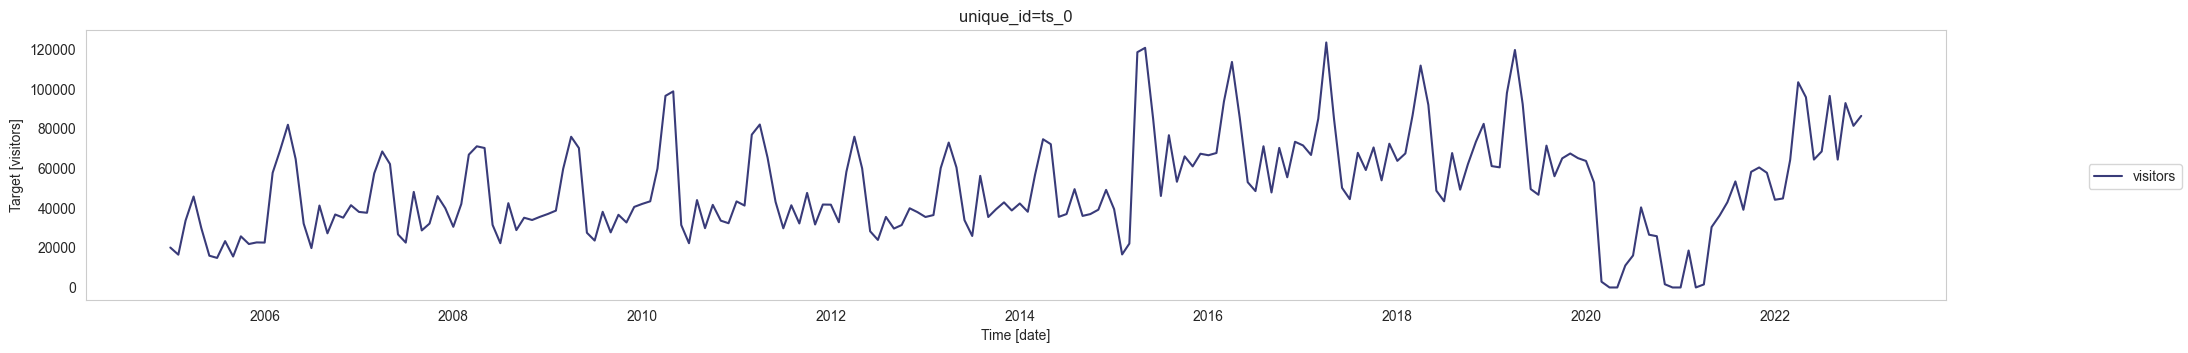

In [7]:
timegpt.plot(egizio_df, time_col='date', target_col='visitors')

Let's analyze how the closing of the museum during COVID-19 affects the forecasting.

Train-test splitting (include all the data)

In [8]:
egizio_train_df = egizio_df[egizio_df['date'].dt.year != 2022]
egizio_test_df = egizio_df[egizio_df['date'].dt.year == 2022]
egizio_train_df.reset_index(drop=True, inplace=True)
egizio_test_df.reset_index(drop=True, inplace=True)

train_size = egizio_train_df.shape[0]
test_size = egizio_test_df.shape[0]
print("Number of rows in training set:", train_size)
print("Number of rows in test set:", test_size)

Number of rows in training set: 204
Number of rows in test set: 12


Standardization

In [9]:
train_visitors_mean = egizio_train_df['visitors'].mean()
train_visitors_std = egizio_train_df['visitors'].std()

egizio_train_df.loc[: ,'visitors'] = (egizio_train_df['visitors'] - train_visitors_mean) / train_visitors_std
egizio_test_df.loc[:, 'visitors'] = (egizio_test_df['visitors'] - train_visitors_mean) / train_visitors_std

print('Standardization complete.')
egizio_train_df.head()

Standardization complete.


,visitors,date
0,-1.162057,2005-01-01
1,-1.308682,2005-02-01
2,-0.607723,2005-03-01
3,-0.112578,2005-04-01
4,-0.763491,2005-05-01


In [10]:
timegpt_fcst_full_df = timegpt.forecast(df=egizio_train_df,
                                        h=test_size,
                                        finetune_steps=10,
                                        freq='M',
                                        time_col='date',
                                        target_col='visitors')
'''
df: A pandas dataframe containing the time series data.
h: The number of steps ahead to forecast.
freq: The frequency of the time series in Pandas format. See pandas’ available frequencies.
time_col: Column that identifies the datestamp column.
target_col: The variable that we want to forecast.
'''
timegpt_fcst_full_df.head(12)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,date,TimeGPT
0,2022-01-01,0.434683
1,2022-02-01,0.509555
2,2022-03-01,0.011781
3,2022-04-01,-0.077386
4,2022-05-01,0.197171
5,2022-06-01,0.362491
6,2022-07-01,0.535603
7,2022-08-01,0.769896
8,2022-09-01,0.481235
9,2022-10-01,0.725586


In [11]:
metrics_df = pd.DataFrame(columns={'description' : str,
                                   'mse': float,
                                   'rmse': float,
                                   'mae': float,
                                   'mape': float})

def calculate_evaluation_metrics(true_values, predicted_values, verbose=False):
    # Calculate metrics: MSE, RMSE, MAE, MAPE
    mse = mean_squared_error(true_values, predicted_values)
    rmse = mean_squared_error(true_values, predicted_values, squared=False)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = mean_absolute_percentage_error(true_values, predicted_values)

    mse = round(mse, 3)
    rmse = round(rmse, 3)
    mae = round(mae, 3)
    mape = round(mape, 3)

    if verbose:
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}")

    return mse, rmse, mae, mape

In [12]:
true_values = egizio_test_df['visitors']
predicted_values = timegpt_fcst_full_df['TimeGPT']

mse, rmse, mae, mape = calculate_evaluation_metrics(true_values, predicted_values)

metrics_df.loc[len(metrics_df.index)] = ['TimeGPT Normal', mse, rmse, mae, mape]

metrics_df.head()

,description,mse,rmse,mae,mape
0,TimeGPT Normal,1.178,1.085,0.903,1.185


C:\Users\Dejan\AppData\Local\Temp\ipykernel_10836\4082645332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egizio_test_df.loc[:, 'train_mean'] = egizio_train_df['visitors'].mean()


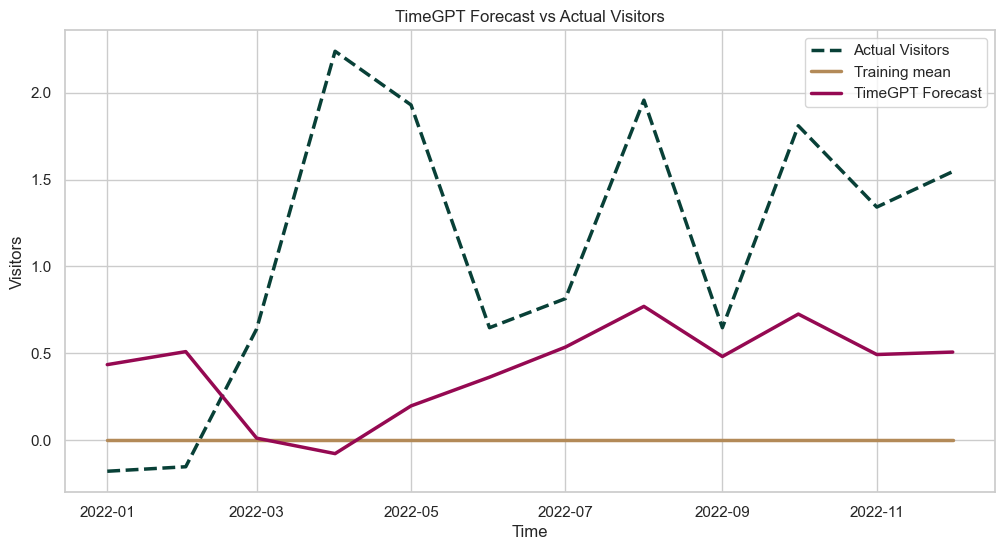

In [13]:
timegpt_fcst_full_df['date'] = egizio_test_df['date'] # It's not of type date, this is a quick fix
egizio_test_df.loc[:, 'train_mean'] = egizio_train_df['visitors'].mean()
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(data=egizio_test_df, x='date', y='visitors', label='Actual Visitors', color='#084037', linewidth = 2.5, linestyle='dashed')
sns.lineplot(data=egizio_test_df, x='date', y='train_mean', label='Training mean', color='#B38A58', linewidth = 2.5)
sns.lineplot(data=timegpt_fcst_full_df, x='date', y='TimeGPT', label='TimeGPT Forecast', color='#950952', linewidth = 2.5)
# #84DCCF
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.title('TimeGPT Forecast vs Actual Visitors')
plt.legend()
plt.show()

Let's plot the data unstandardized, along with the predictions.

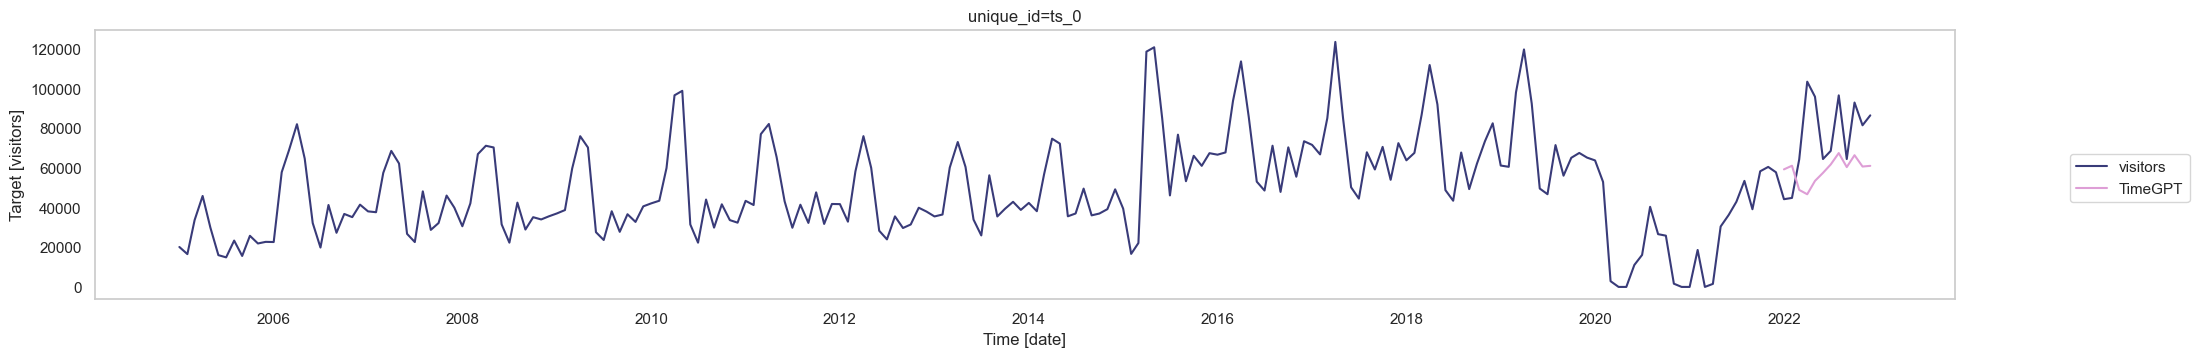

In [14]:
timegpt_fcst_full_df['TimeGPT'] = timegpt_fcst_full_df['TimeGPT'] * train_visitors_std + train_visitors_mean
timegpt.plot(egizio_df, timegpt_fcst_full_df, time_col='date', target_col='visitors')

We can observe that the model underestimates the test data.

Let's also include confidence intervals in the predictions:

In [15]:
timegpt_fcst_full_pred_int_df = timegpt.forecast(df=egizio_train_df,
                                                 h=12,
                                                 level=[80, 90, 99.7],
                                                 time_col='date',
                                                 target_col='visitors')

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Restricting input...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


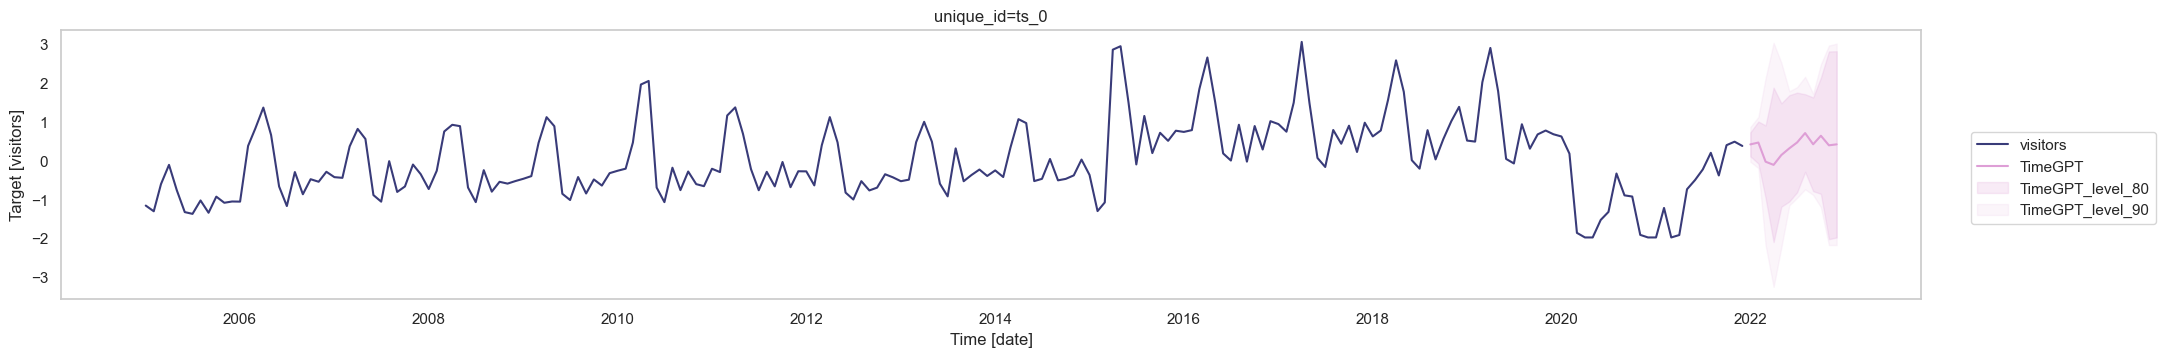

In [16]:
timegpt.plot(egizio_train_df, timegpt_fcst_full_pred_int_df,
             time_col='date', target_col='visitors',
             level=[80, 90])

Historical forecast


We can also compute prediction intervals for historical forecasts adding the add_history=True parameter as follows:

In [17]:
timegpt_fcst_full_pred_int_df = timegpt.forecast(df=egizio_train_df,
                                                 h=12,
                                                 level=[80, 90, 99.7],
                                                 time_col='date',
                                                 target_col='visitors',
                                                 add_history=True)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


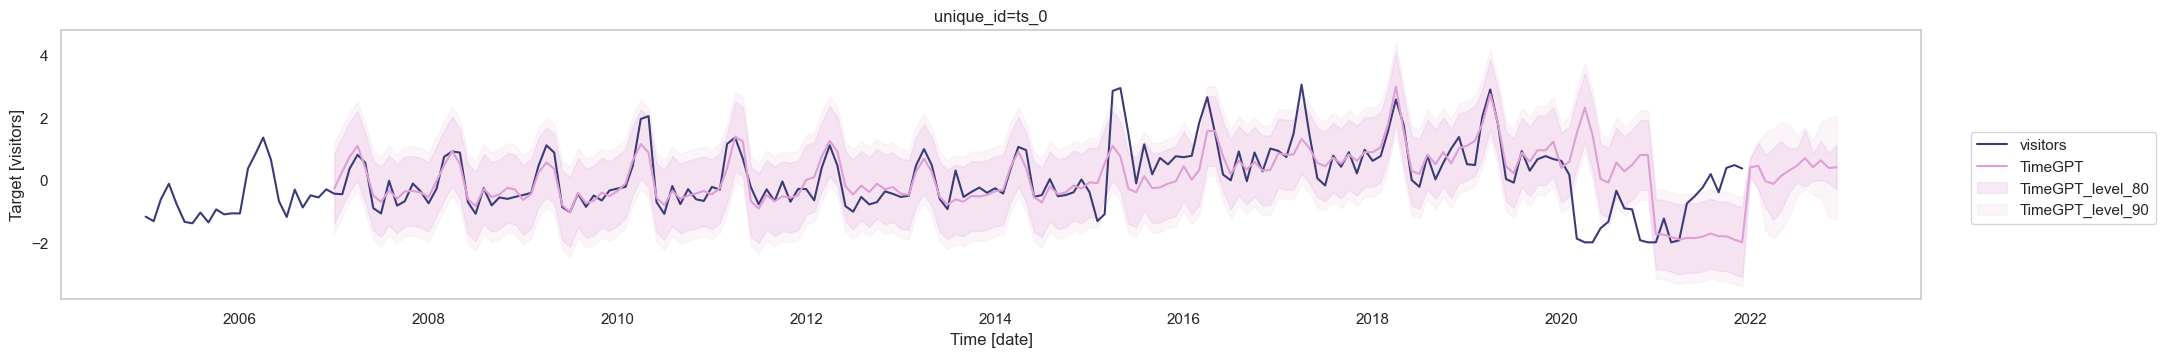

In [18]:
timegpt.plot(egizio_train_df,
             timegpt_fcst_full_pred_int_df,
             time_col='date',
             target_col='visitors',
             level=[80, 90])

Above we saw that the COVID period affects the forecasting on the test set, making our model underestimate the data. Can we consider this period as outliers? Let's ask TimeGPT by using the "detect anomalies" feature:

In [19]:
timegpt_anomalies_df = timegpt.detect_anomalies(egizio_df,
                                                time_col='date',
                                                target_col='visitors',
                                                freq='M',
                                                date_features=True,
                                                level=99.5)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


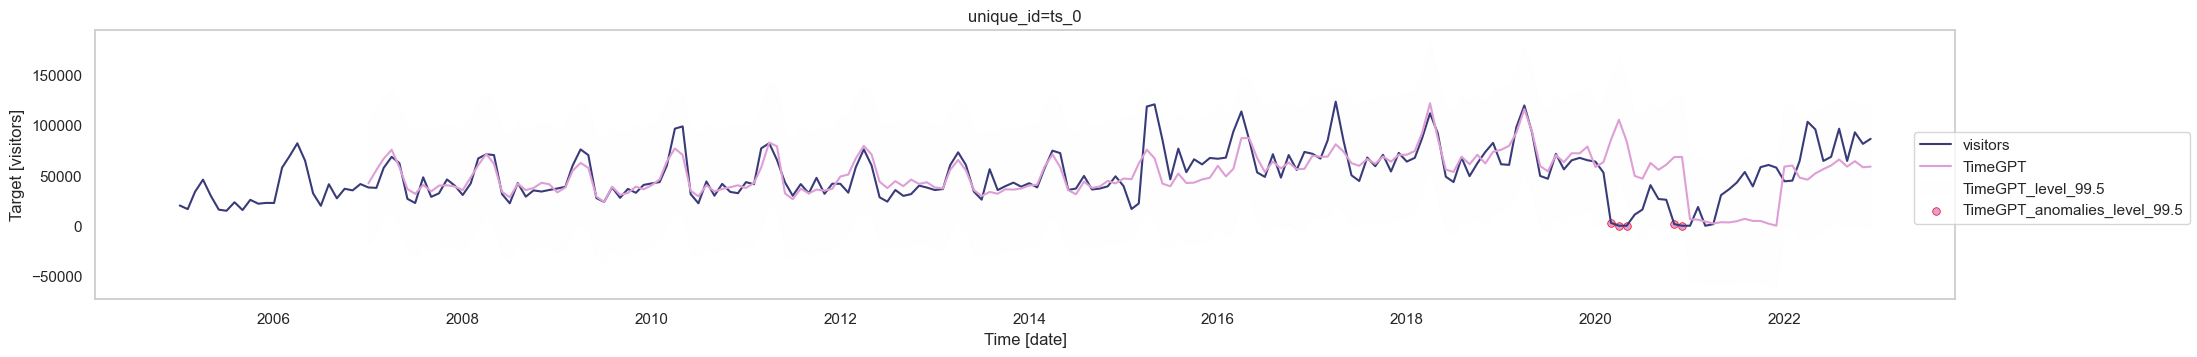

In [20]:
timegpt.plot(egizio_df,
             timegpt_anomalies_df,
             time_col='date',
             target_col='visitors')

As we can see with 0.5% error, COVID months are regarded as anomalies (outliers).\
Let's try to interpolate this data.

Model 2 (don't include COVID months in the data)\
Train-test splitting

In [21]:
egizio_train_no_covid_df = egizio_df[(egizio_df['date'].dt.year < 2020)]
egizio_test_df = egizio_df[egizio_df['date'].dt.year == 2022]
egizio_train_no_covid_df.reset_index(drop=True, inplace=True)
egizio_test_df.reset_index(drop=True, inplace=True)

timegpt_fcst_covid_df = timegpt.forecast(df=egizio_train_no_covid_df,
                                        h=24, # 2 years
                                        finetune_steps=10,
                                        freq='M',
                                        time_col='date',
                                        target_col='visitors')
timegpt_fcst_covid_df.head(3)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,date,TimeGPT
0,2020-01-01,56259.300781
1,2020-02-01,62108.164062
2,2020-03-01,89155.031250


In [22]:
timegpt_fcst_covid_df.rename(columns={'TimeGPT' : 'visitors'}, inplace=True)
egizio_train_synthetic_df = pd.concat([egizio_train_no_covid_df, timegpt_fcst_covid_df], ignore_index=True)

train_size = egizio_train_synthetic_df.shape[0]
test_size = egizio_test_df.shape[0]
print("Number of rows in training set:", train_size)
print("Number of rows in test set:", test_size)

Number of rows in training set: 204
Number of rows in test set: 12


In [23]:
egizio_train_synthetic_df.head()

,visitors,date
0,20123.0,2005-01-01 00:00:00
1,16531.0,2005-02-01 00:00:00
2,33703.0,2005-03-01 00:00:00
3,45833.0,2005-04-01 00:00:00
4,29887.0,2005-05-01 00:00:00


Standardization

In [24]:
train_synthetic_visitors_mean = egizio_train_synthetic_df['visitors'].mean()
train_syntethic_visitors_std = egizio_train_synthetic_df['visitors'].std()

egizio_train_synthetic_df.loc[: ,'visitors'] = (egizio_train_synthetic_df['visitors'] - train_synthetic_visitors_mean) / train_syntethic_visitors_std
egizio_test_df.loc[:, 'visitors'] = (egizio_test_df['visitors'] - train_synthetic_visitors_mean) / train_syntethic_visitors_std

print('Standardization complete.')
egizio_train_synthetic_df.head()

Standardization complete.


,visitors,date
0,-1.417443,2005-01-01 00:00:00
1,-1.567212,2005-02-01 00:00:00
2,-0.851221,2005-03-01 00:00:00
3,-0.345458,2005-04-01 00:00:00
4,-1.010330,2005-05-01 00:00:00


In [25]:
timegpt_fcst_synthetic_df = timegpt.forecast(df=egizio_train_synthetic_df,
                                              h=test_size,
                                              finetune_steps=10,
                                              freq='M',
                                              time_col='date',
                                              target_col='visitors')

timegpt_fcst_synthetic_df['date'] = egizio_test_df['date']

timegpt_fcst_synthetic_df.head(12)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,date,TimeGPT
0,2022-01-01,0.434251
1,2022-02-01,0.835281
2,2022-03-01,2.207419
3,2022-04-01,3.746808
4,2022-05-01,2.418192
5,2022-06-01,0.302027
6,2022-07-01,0.186857
7,2022-08-01,0.827051
8,2022-09-01,0.796513
9,2022-10-01,0.907825


In [26]:
true_values = egizio_test_df['visitors']
predicted_values_synthetic = timegpt_fcst_synthetic_df['TimeGPT']

mse, rmse, mae, mape = calculate_evaluation_metrics(true_values, predicted_values_synthetic)

metrics_df.loc[len(metrics_df.index)] = ['COVID interpolated', mse, rmse, mae, mape]

metrics_df.head()

,description,mse,rmse,mae,mape
0,TimeGPT Normal,1.178,1.085,0.903,1.185
1,COVID interpolated,0.876,0.936,0.762,1.146


Both the RMSE and MAPE decreased. So, the interpolation was successful.

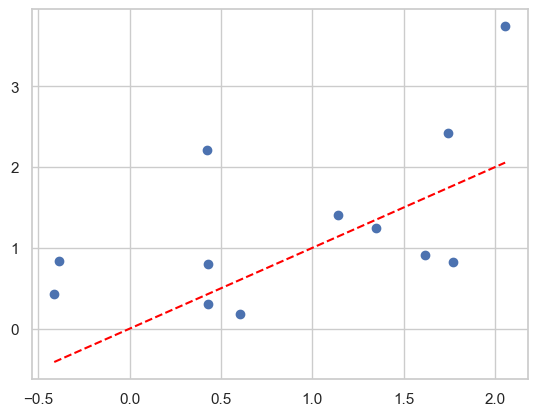

In [27]:
plt.scatter(true_values, predicted_values_synthetic)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--')
plt.show()

Plot forecasted vs actual values

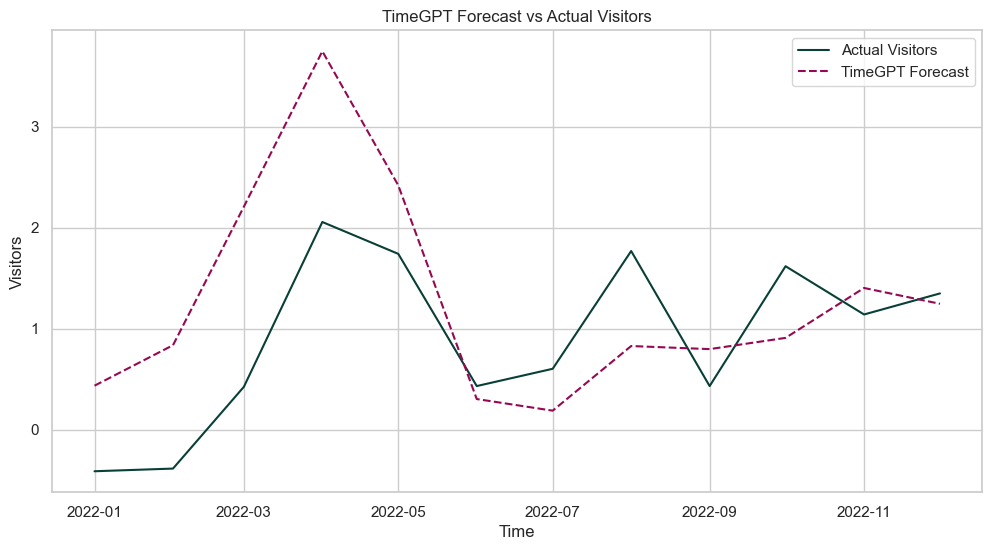

In [28]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(data=egizio_test_df, x='date', y='visitors', label='Actual Visitors', color='#084037')
sns.lineplot(data=timegpt_fcst_synthetic_df, x='date', y='TimeGPT', label='TimeGPT Forecast', color='#950952', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.title('TimeGPT Forecast vs Actual Visitors')
plt.legend()
plt.show()

We can see that the forecast more closely follows the test data after the interpolation.

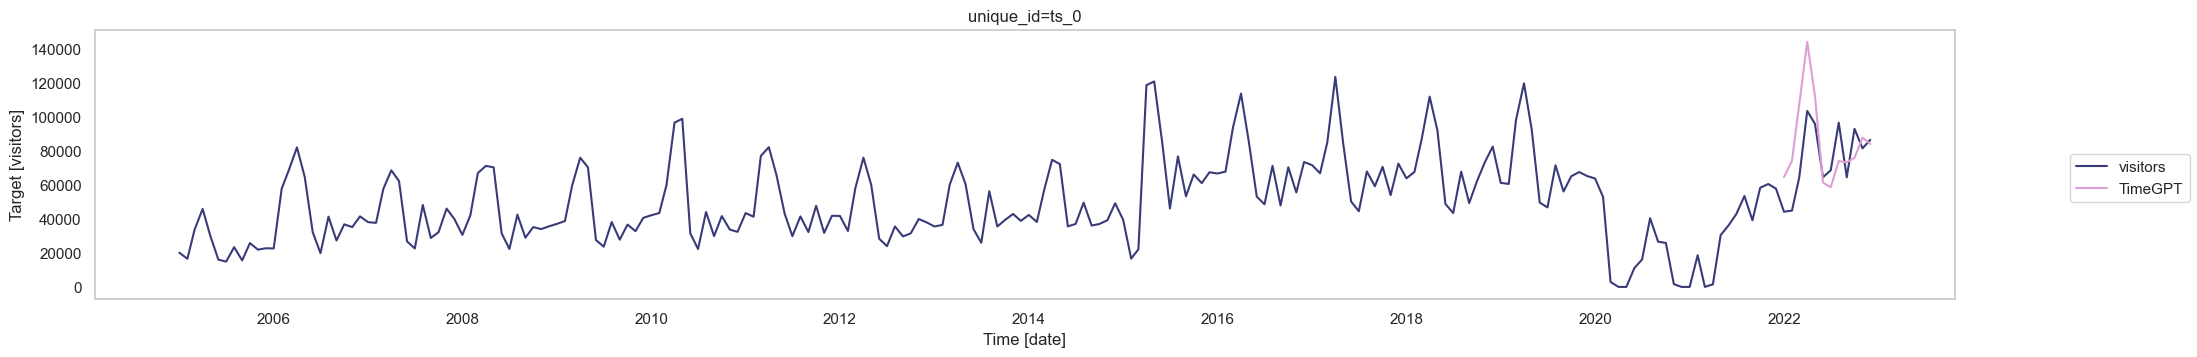

In [29]:
timegpt_fcst_synthetic_df['TimeGPT'] = timegpt_fcst_synthetic_df['TimeGPT'] * train_syntethic_visitors_std + train_synthetic_visitors_mean
timegpt.plot(egizio_df, timegpt_fcst_synthetic_df, time_col='date', target_col='visitors')

Model 3 - xreg
Finally, let's try to use exogeneous variables to improve the predictions. For this we will stick to the setup of the first model.

In [30]:
google_trends_df = pd.read_csv('museo_egizio_google_trends.csv')
egizio_df['google_trends'] = google_trends_df['trends']

italy_holidays_df = pd.read_csv('italy_holidays.csv')
egizio_df['holidays'] = italy_holidays_df['hl_sch']

weather_df = pd.read_csv('turin_weather.csv')
egizio_df['average_temperature'] = weather_df['average_temperature']
egizio_df['raining_days'] = weather_df['raining_days']

tourists_df = pd.read_csv('turin_arrivals.csv')
egizio_df['tourists'] = tourists_df['arrivals']

covid_lockdown_df = pd.read_csv('Covid19_closures.csv')
egizio_df['museum_closed'] = covid_lockdown_df['Covid_closures']

renovation_df = pd.read_csv('museo_egizio_renovation.csv')
egizio_df['renovation'] = renovation_df['renovation']

egizio_df.head()

,visitors,date,google_trends,holidays,average_temperature,raining_days,tourists,museum_closed,renovation
0,20123,2005-01-01,64,6,1.3,0,25923,0,0
1,16531,2005-02-01,62,3,1.6,3,28065,0,0
2,33703,2005-03-01,40,3,7.6,8,27809,0,0
3,45833,2005-04-01,69,2,11.2,15,29488,0,0
4,29887,2005-05-01,49,1,18.5,9,35919,0,0


In [31]:
egizio_df.dtypes

visitors                        int32
date                   datetime64[ns]
google_trends                   int64
holidays                        int64
average_temperature           float64
raining_days                    int64
tourists                        int64
museum_closed                   int64
renovation                      int64
dtype: object

In [32]:
egizio_train_df = egizio_df[egizio_df['date'].dt.year != 2022]
egizio_test_df = egizio_df[egizio_df['date'].dt.year == 2022]
egizio_train_df.reset_index(drop=True, inplace=True)
egizio_test_df.reset_index(drop=True, inplace=True)

train_size = egizio_train_df.shape[0]
test_size = egizio_test_df.shape[0]
print("Number of rows in training set:", train_size)
print("Number of rows in test set:", test_size)

Number of rows in training set: 204
Number of rows in test set: 12


In [33]:
egizio_future_df = egizio_test_df.copy()
egizio_future_df = egizio_future_df.drop(columns=['visitors'])
egizio_future_df = egizio_future_df.rename(columns={'date': 'ds'})
egizio_train_df = egizio_train_df.rename(columns={'date': 'ds', 'visitors' : 'y'})

In [34]:
timegpt_fcst_ex_vars_df = timegpt.forecast(df=egizio_train_df,
                                           finetune_steps=10,
                                           X_df=egizio_future_df,
                                           h=12,
                                           level=[80, 90])
timegpt_fcst_ex_vars_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,2022-01-01,71521.817228,64140.818400,64488.905119,78554.729338,78902.816056
1,2022-02-01,51775.511142,32897.768564,33630.392002,69920.630283,70653.253720
2,2022-03-01,38807.733066,268.121152,17987.916660,59627.549472,77347.344980
3,2022-04-01,40618.698363,-2114.445387,12486.654613,68750.742113,83351.842113
4,2022-05-01,30680.713737,-11643.845638,3599.635099,57761.792374,73005.273112


Let's visualize the calculated feature importance:

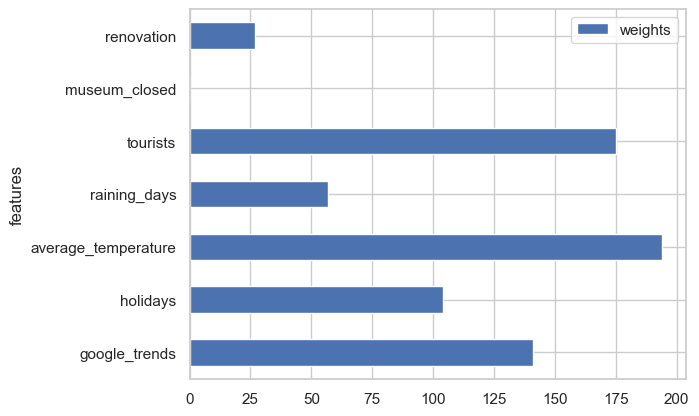

In [35]:
timegpt.weights_x.plot.barh(x='features', y='weights')
plt.show()

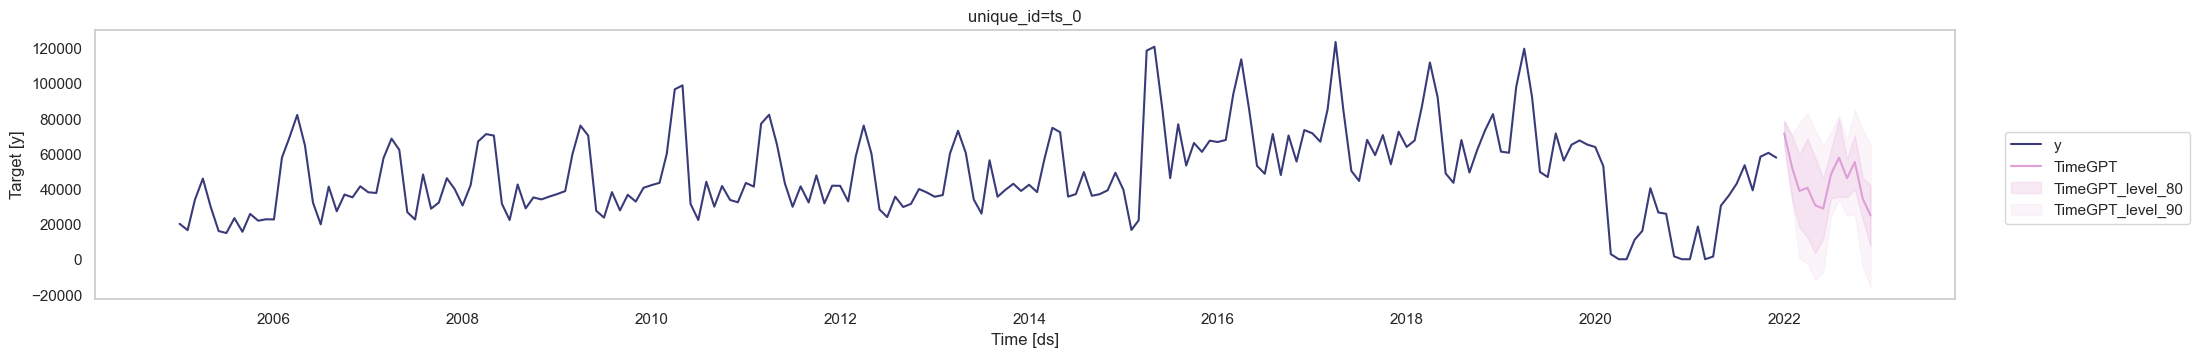

In [36]:
timegpt.plot(egizio_train_df[['ds', 'y']],
             timegpt_fcst_ex_vars_df,
             max_insample_length=365,
             level=[80, 90])

Cross validation

In [37]:
egizio_train_df = egizio_train_df.rename(columns={'ds': 'date', 'y' : 'visitors'})
egizio_train_df.head()

,visitors,date,google_trends,holidays,average_temperature,raining_days,tourists,museum_closed,renovation
0,20123,2005-01-01,64,6,1.3,0,25923,0,0
1,16531,2005-02-01,62,3,1.6,3,28065,0,0
2,33703,2005-03-01,40,3,7.6,8,27809,0,0
3,45833,2005-04-01,69,2,11.2,15,29488,0,0
4,29887,2005-05-01,49,1,18.5,9,35919,0,0


In [38]:
timegpt_cv_df = timegpt.cross_validation(egizio_train_df,
                                         h=12,
                                         n_windows=5,
                                         time_col='date',
                                         target_col='visitors',
                                         freq='M')
timegpt_cv_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixt

,date,cutoff,visitors,TimeGPT
0,2017-01-01,2016-12-01,71577,69638.500000
1,2017-02-01,2016-12-01,66775,68528.281250
2,2017-03-01,2016-12-01,85061,68774.476562
3,2017-04-01,2016-12-01,123457,81007.742188
4,2017-05-01,2016-12-01,84862,73824.093750


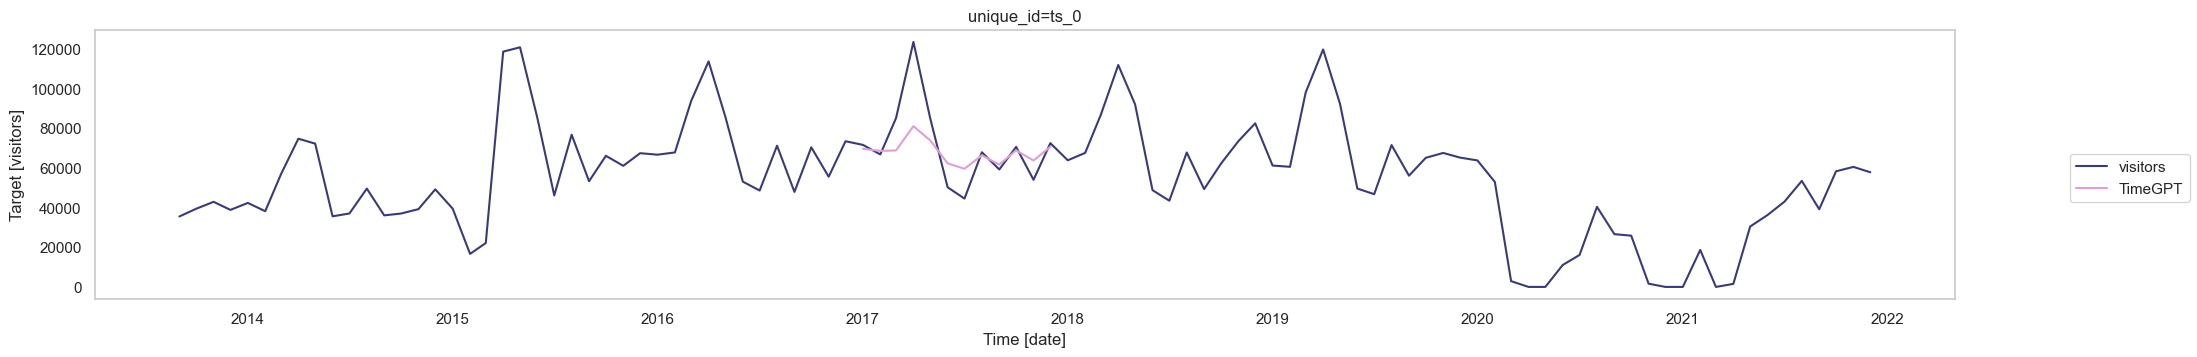

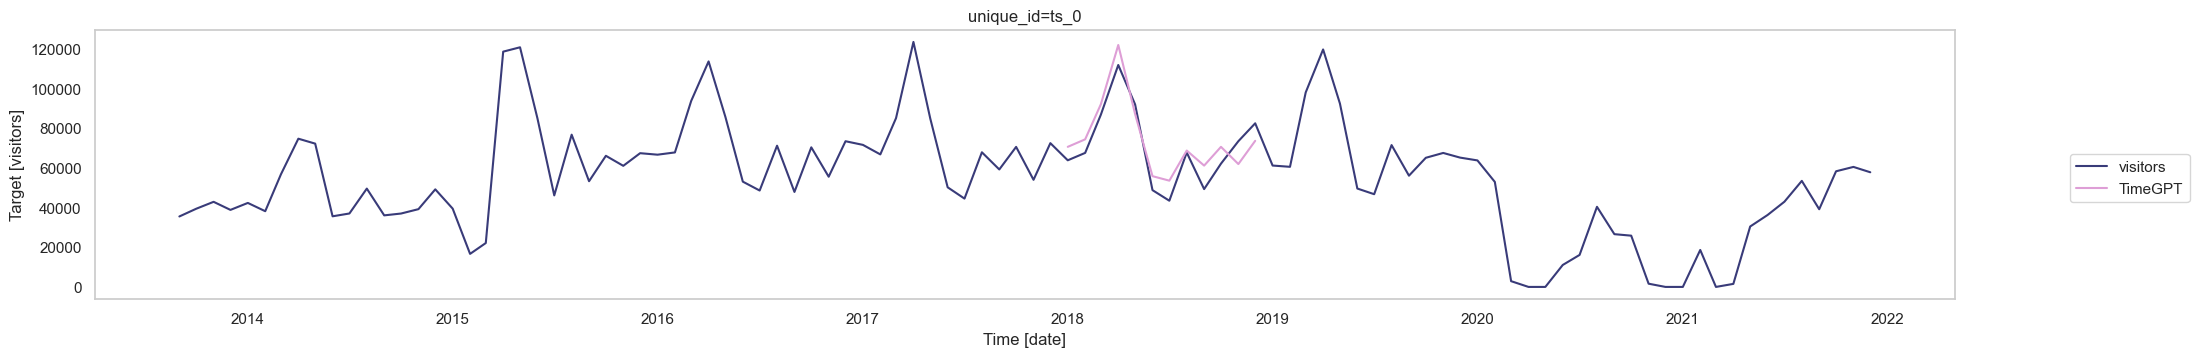

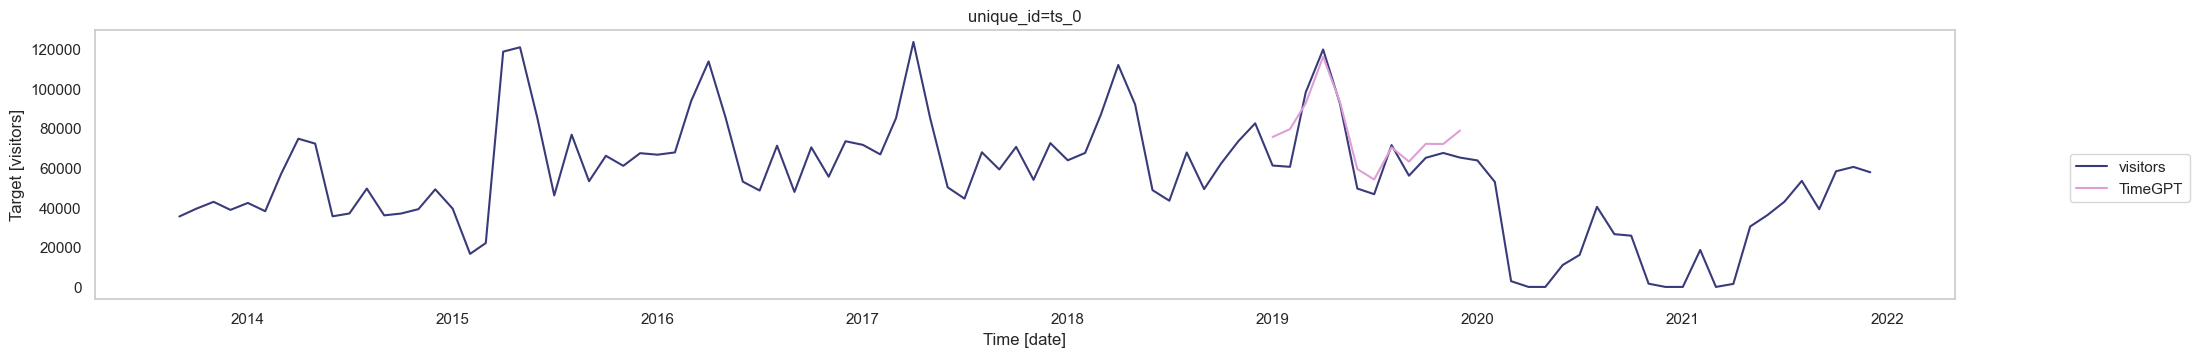

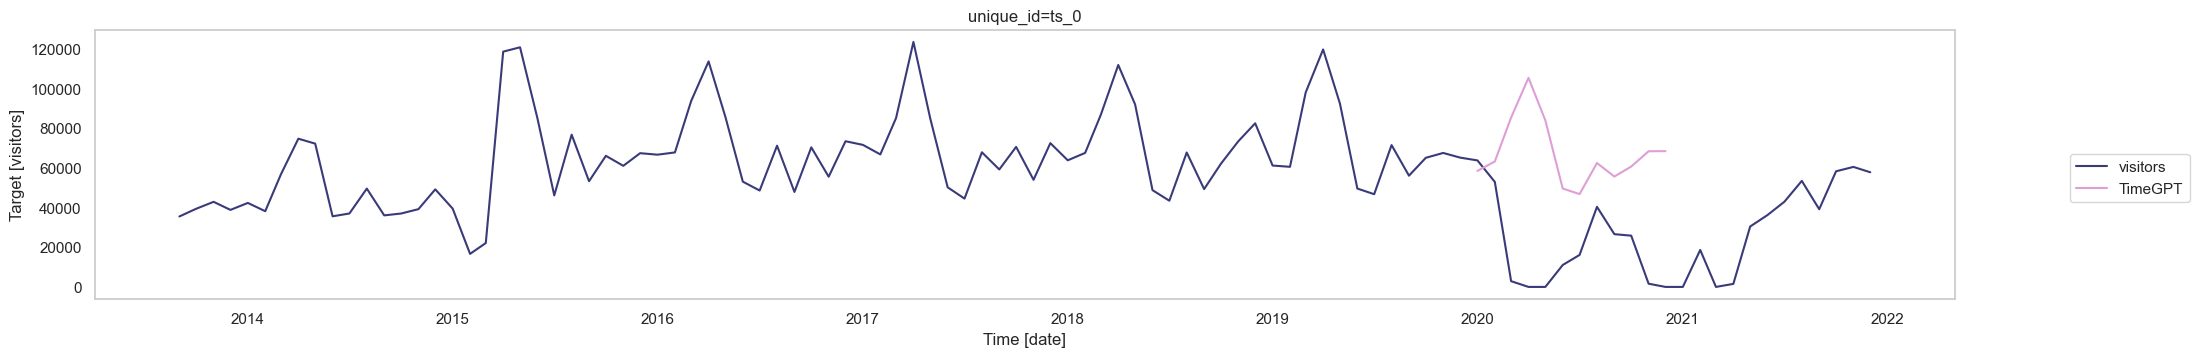

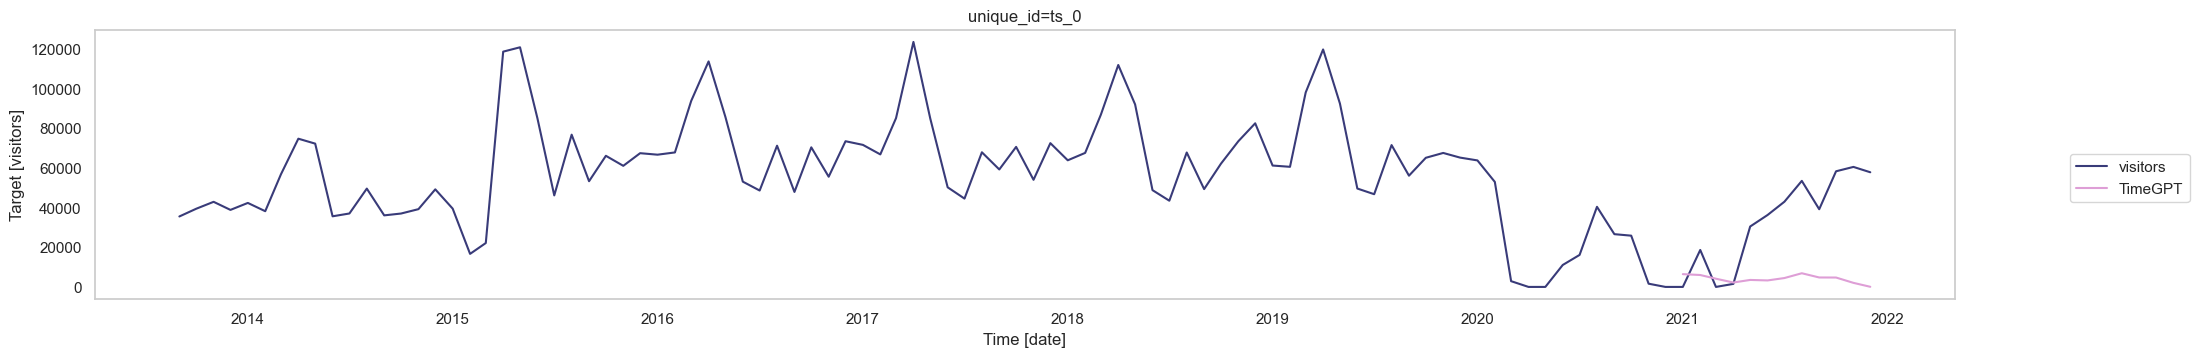

In [39]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = timegpt.plot(egizio_train_df.tail(100),
                       timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'visitors']),
                       time_col='date',
                       target_col='visitors')
    display(fig)

In [40]:
true_values = egizio_test_df['visitors']
true_values = (true_values - train_visitors_mean) / train_visitors_std
predicted_values_restricted = timegpt_cv_df['TimeGPT']
predicted_values_restricted = (predicted_values_restricted - train_visitors_mean) / train_visitors_std

mse, rmse, mae, mape = calculate_evaluation_metrics(true_values, predicted_values, True)

MSE: 1.18
RMSE: 1.08
MAE: 0.90
MAPE: 1.19


Normalization is needed.

In [41]:
timegpt_cv_df.head(12)

,date,cutoff,visitors,TimeGPT
0,2017-01-01,2016-12-01,71577,69638.500000
1,2017-02-01,2016-12-01,66775,68528.281250
2,2017-03-01,2016-12-01,85061,68774.476562
3,2017-04-01,2016-12-01,123457,81007.742188
4,2017-05-01,2016-12-01,84862,73824.093750
5,2017-06-01,2016-12-01,50197,62262.226562
6,2017-07-01,2016-12-01,44502,59530.855469
7,2017-08-01,2016-12-01,67844,66350.992188
8,2017-09-01,2016-12-01,59185,61596.464844
9,2017-10-01,2016-12-01,70563,68845.515625


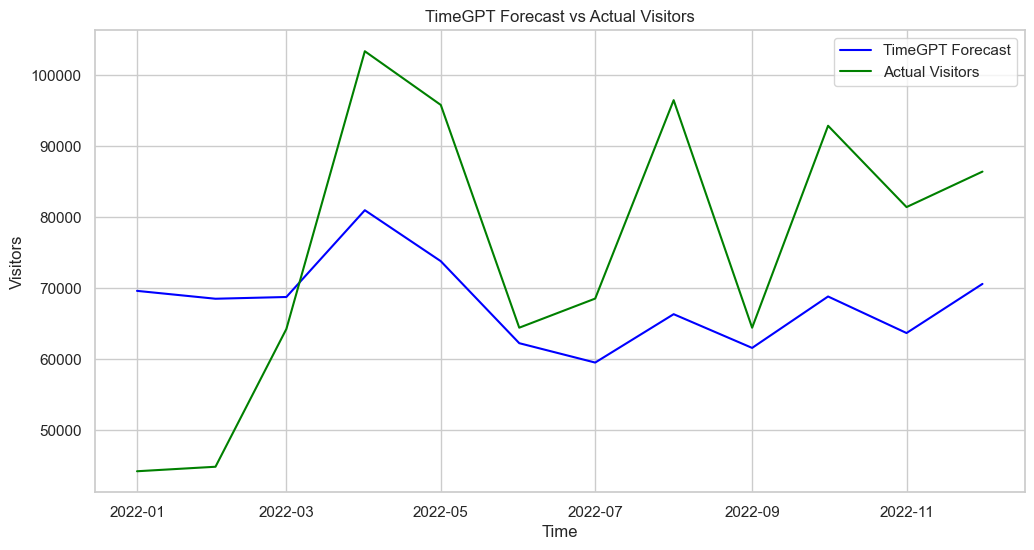

In [42]:
timegpt_cv_df['date'] = egizio_test_df['date']
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(data=timegpt_cv_df, x='date', y='TimeGPT', label='TimeGPT Forecast', color='blue')
sns.lineplot(data=egizio_test_df, x='date', y='visitors', label='Actual Visitors', color='green')
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.title('TimeGPT Forecast vs Actual Visitors')
plt.legend()
plt.show()